# Image Captioning Assessment

**Hello everyone!**

In this assessment, the task is to `generate captions` for images using the `Flickr 8K dataset`.

---

### Dataset Overview:

- **Number of Images:** 8000
- **Captions per Image:** 5

---
<font color = 'lightblue'>The primary goal is to develop a model capable of generating meaningful and contextually relevant captions for these images</font>. Additionally, part of the assessment involves analyzing each generated caption to determine its `sentiment`.

**Sentiment Analysis:**
- Utilize sentiment analysis techniques to assess the emotional tone and context conveyed by each caption.


## Import library we need

In [ ]:
!pip install emoji

In [ ]:
import numpy as np
import pickle
import os
import tensorflow as tf
import PIL
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop , Adamax , Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical , plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Dropout, add , LSTM, Embedding
from PIL import Image
import matplotlib.pyplot as plt
import emoji

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Loading Captions
---


*   split `image` and `caption`



In [ ]:
caption_file_path = '/content/drive/MyDrive/Assessment/captions8K.txt'   # path of caption file (.txt)

In [ ]:
def caption_load(fileName):
    with open(fileName) as file:
        data = file.readlines() # reading all the line from caption.txt
        mapping = {}
        for line in data:
            eachline = line.rstrip('\n')  # seperate each line
            tokens = eachline.split(',')  # split name + .jpg  and captions
            if len(eachline) < 2:
                continue
            # define image and caption
            image, caption = tokens[0], tokens[1:]  # (name + .jpg) => image   and  (captions) => caption
            image = image.split('.')[0]  # split .jpg from name of image
            caption = " ".join(caption)
            if image not in mapping:
                mapping[image] = []
            mapping[image].append(caption)
    return mapping

In [ ]:
captions_mapping = caption_load(caption_file_path)  #call the function to load caption and save it into captions_mapping

In [ ]:
len(captions_mapping)

8091

# <font color = 'lightblue'> Pre-Processing in Caption </font>

---

*   Remove any digit and special character
*   Remove any additional space
*   Add a boundary to each line of the caption




In [ ]:
def clean_caption(captions_mapping):
    for _, captions in captions_mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower() # convert to lowercase
            caption = caption.replace('[^A-Za-z]', '') # only character
            caption = caption.replace('\s+', ' ') # delete space
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq' # remove single characters ,,, add start and end to begginig and ending of a sentence
            captions[i] = caption

In [ ]:
clean_caption(captions_mapping)  #call the function

# What's Happening in the `caption.txt` File?

---

For instance ⚡

Here's an example of an image along with its caption: **1001773457_577c3a7d70.jpg**

1. **Key (`1001773457_577c3a7d70`):** This is the unique identifier we refer to as the **key**.
2. **Caption:** *A black dog and a spotted dog are fighting.* This descriptive text is the **caption** associated with the image.


In [ ]:
captions = []
for key in captions_mapping:   # key here is name of image
    for value in captions_mapping[key]:  # value here is the caption for image
        captions.append(value)

In [ ]:
token = Tokenizer()
token.fit_on_texts(captions)    # encoded and build a vocabulary
vocab_size = len(token.word_index) + 1

In [ ]:
max_length = max(len(caption.split()) for caption in captions)    # find the longest caption in the caption.txt

# `Extract Features` from Image by using Pre-trained Model

In [ ]:
# load model
#pre_trained_model = ResNet50()
pre_trained_model = VGG16(weights='imagenet')
#pre_trained_model = InceptionV3(weights='imagenet')

In [ ]:
pre_trained_model.save('/content/drive/MyDrive/Assessment/VGG16_pre_trained_model.h5')

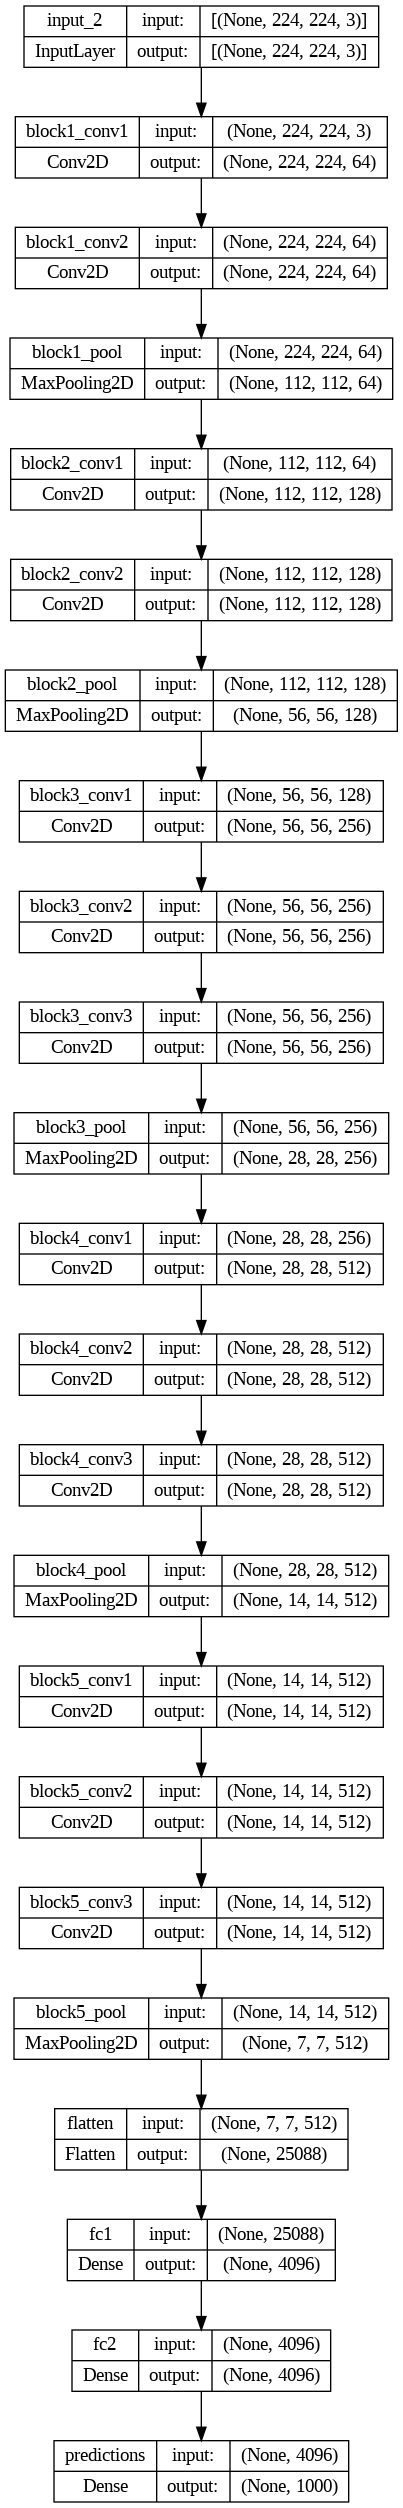

In [ ]:
#we can see the model structure
plot_model(pre_trained_model, show_shapes=True)  #outputResnet ==> None , 1000  , , , VGG16 ==>None, 1000 , , , InceptionV3 ==> -_-

In [ ]:
pre_trained_model = tf.keras.models.load_model('/content/drive/MyDrive/Assessment/VGG16_pre_trained_model.h5')   #load the pre-trained Model

In [ ]:
# path to image folder
image_path_file = '/content/drive/MyDrive/Assessment/Images8K'

In [ ]:
''' from google.colab import drive
drive.mount('/content/drive') '''

" from google.colab import drive\ndrive.mount('/content/drive') "

In [ ]:
# function to encode features
def extract_features(directory_path):
  features = {}
  image_files = [f.strip() for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]
  for imageName in image_files:
      image_path = os.path.join(directory_path, imageName)
      image = load_img(image_path, target_size=(224, 224,3))
      image = img_to_array(image)
      image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
      image = preprocess_input(image)
      feature = pre_trained_model.predict(image, verbose=0)   # Extract features
      image_values = imageName.split('.')[0]    # split to have only name of image not .jpg
      features[image_values] = feature
  return features

In [ ]:
extracted_features = extract_features(image_path_file)  # call the function

### `Save and load features`

extracting features for large dataset take more time 8K take 5min ,,, 30k 21min

In [ ]:
path = '/content/drive/MyDrive/Assessment/feature'

In [ ]:
features_file_path = os.path.join(path, 'featuresVGG16.pkl')

In [ ]:
with open(features_file_path, 'wb') as features_file:  # save features
    pickle.dump(extracted_features, features_file)

In [ ]:
with open(os.path.join(path, 'featuresVGG16.pkl'), 'rb') as f: # load features
    features = pickle.load(f)

### **Split** Data into :


*   **Train** 81%
*   **test** 10%
*   **val**  9%



In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
def split_for_training(mapping):
    image_value = list(mapping.keys())
    train_temp , test = train_test_split(image_value,random_state=40 , train_size=0.9 , test_size=0.1 , shuffle=True)
    train , val = train_test_split(train_temp,random_state=40 , train_size=0.9 , test_size=0.1, shuffle=True)
    return train , val , test

In [ ]:
train , val , test = split_for_training(captions_mapping)

In [ ]:
def Custom_data_generate(keys, mapping, token, max_length,vocab_size, batch_size, features):
    # loop over images
    feature_data, X, y = list(), list(), list()
    n = 0
    while True:
        for key in keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                sequence = token.texts_to_sequences([caption])[0]

                for i in range(1, len(sequence)):
                    # split into input and output pairs
                    input_seq, output_seq = sequence[:i], sequence[i]
                    # pad input sequence
                    input_seq = pad_sequences([input_seq], maxlen=max_length)[0]
                    # encode output sequence
                    output_seq = to_categorical([output_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    feature_data.append(features[key][0])
                    X.append(input_seq)
                    y.append(output_seq)
            if n == batch_size:
                feature_data, X, y = np.array(feature_data), np.array(X), np.array(y)
                yield [feature_data, X], y
                feature_data, X, y = list(), list(), list()
                n = 0

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)    # using EarlyStopping to stop and save the best epoch when val-loss dose not decrease after 3 epochs

In [ ]:
# Load pre-trained embeddings
embeddings_index = {}
with open('/content/drive/MyDrive/Assessment/glove/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((vocab_size, 100))
for word, i in token.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### building a model with `two input` branches, one for `image features` and another for `text features`

In [ ]:
from tensorflow.keras.layers import Attention

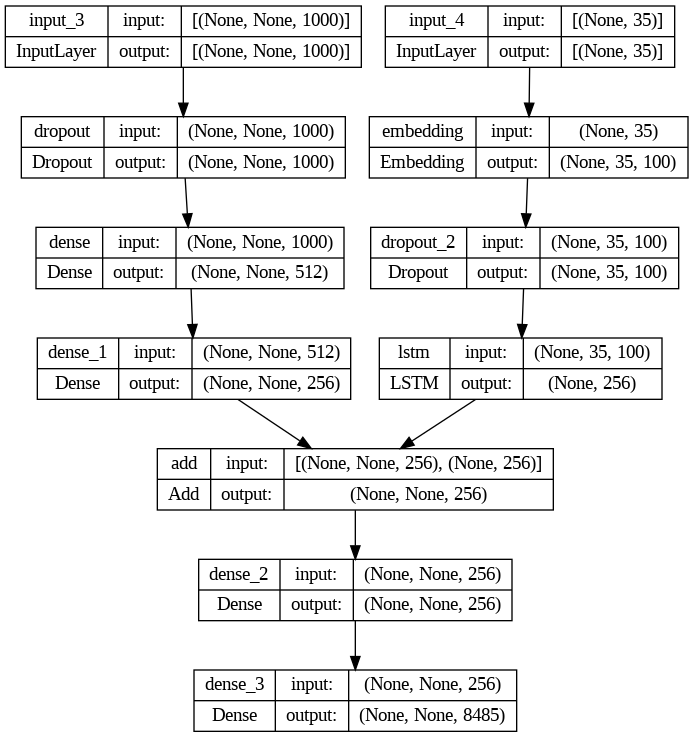

In [ ]:
# encoder model
# image feature layers (image)
inputs1 = Input(shape=(None, 1000))
image_feature1 = Dropout(0.5)(inputs1)
image_feature2 = Dense(512, activation='relu')(image_feature1)
image_feature2_dropout = Dropout(0.3)(image_feature2)
image_feature3 = Dense(256, activation='relu')(image_feature2)
# text feature layers (text)
inputs2 = Input(shape=(max_length,))
text_feature1 = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False)(inputs2)
text_feature2 = Dropout(0.5)(text_feature1)
text_feature3 = LSTM(256)(text_feature2)
# decoder model

decoder1 = add([image_feature3, text_feature3]) # combining them using a simple concatenation (add) operation
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)    #output activation-function must be softmax
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='RMSprop')

# plot the model
plot_model(model, show_shapes=True)

In [ ]:
epochs = 30
batch_size = 32
steps = len(train) // batch_size
validation_step = len(val) // batch_size
generator = Custom_data_generate(train, captions_mapping, token, max_length, vocab_size, batch_size,features)
valid = Custom_data_generate(val, captions_mapping, token, max_length, vocab_size, batch_size,features)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, callbacks=[early_stopping] ,validation_data=valid,validation_steps=validation_step, verbose=1)

Epoch 1/30
204/204 [==============================] - 48s 215ms/step - loss: 5.6215 - val_loss: 5.0342
Epoch 2/30
204/204 [==============================] - 42s 205ms/step - loss: 4.8938 - val_loss: 4.6472
Epoch 3/30
204/204 [==============================] - 41s 200ms/step - loss: 4.6247 - val_loss: 4.4084
Epoch 4/30
204/204 [==============================] - 40s 195ms/step - loss: 4.4265 - val_loss: 4.2421
Epoch 5/30
204/204 [==============================] - 42s 207ms/step - loss: 4.2819 - val_loss: 4.1165
Epoch 6/30
204/204 [==============================] - 42s 205ms/step - loss: 4.1693 - val_loss: 4.0210
Epoch 7/30
204/204 [==============================] - 41s 199ms/step - loss: 4.0815 - val_loss: 3.9479
Epoch 8/30
204/204 [==============================] - 40s 197ms/step - loss: 4.0071 - val_loss: 3.8740
Epoch 9/30
204/204 [==============================] - 41s 202ms/step - loss: 3.9410 - val_loss: 3.8394
Epoch 10/30
204/204 [==============================] - 41s 202ms/step - l

In [ ]:
model.save('/content/drive/MyDrive/Assessment/image_caption_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Assessment/image_caption_model.h5')

## <font color='lightblue'>Caption Generate for Images</font>

---
* decode

In [ ]:
def decode_word(integer,token):
    for word, index in token.word_index.items():
        if index==integer:
            return word
    return None

#### function for generating a caption for an image

In [ ]:
def predict_caption(model, image, token, max_length):   # token using encode and decode

    input_text = 'startseq'   # add start tag for generation process
    for _ in range(max_length):   # iterate over the max length of sequence
        sequence = token.texts_to_sequences([input_text])[0]  # encode input sequence
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)  # predict next word
        yhat = np.argmax(yhat)    # get index with high probability
        word = decode_word(yhat, token)  # convert index to word  (decode)
        if word is None:
            break
        input_text += " " + word  # append word as input for generating next word
        if word == 'endseq':   # stop if we reach end tag
            break

    return input_text

In [ ]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
nltk.download('vader_lexicon')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def analyze_sentiment(caption):
    sid = SentimentIntensityAnalyzer()
    sentiment_scores = sid.polarity_scores(caption)

    # Interpret sentiment scores
    if sentiment_scores['compound'] >= 0.05:
        return '😊'
    elif sentiment_scores['compound'] <= -0.05:
        return '😞'
    else:
        return '😐'

##  <font color = 'lightgreen'>Now let's Testing </font>

Caption: black and white dog is running through the water |||| sentiment: 😐


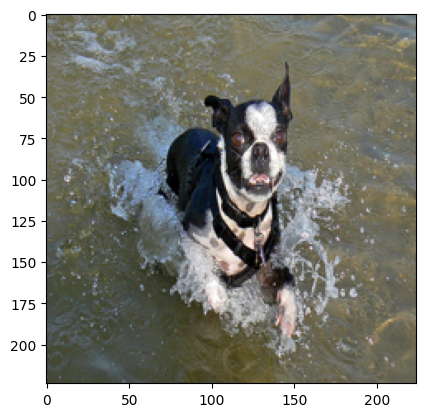

Caption: man is riding bull on the sidewalk |||| sentiment: 😐


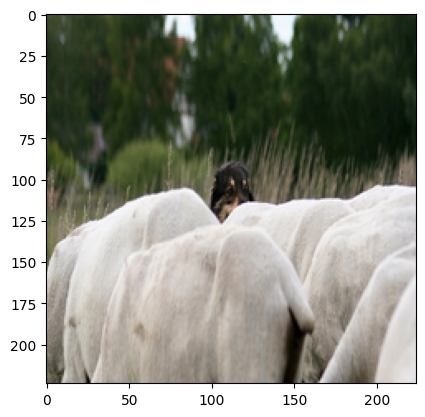

Caption: brown dog is running through the snow |||| sentiment: 😐


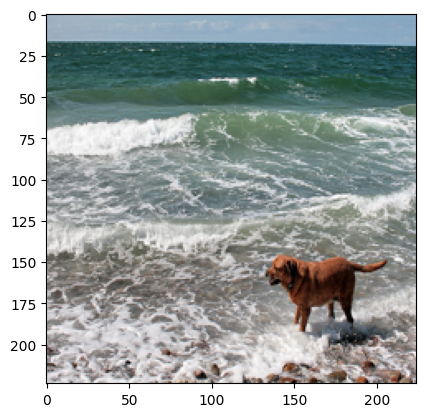

Caption: man in red shirt is standing on the sidewalk with his arms outstretched |||| sentiment: 😐


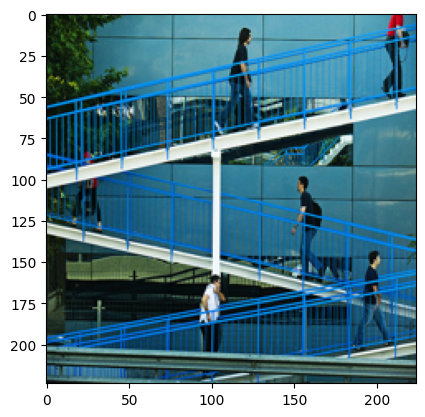

Caption: man in red shirt is standing in front of large building |||| sentiment: 😐


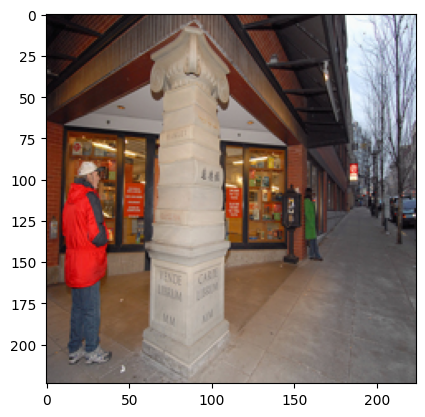

Caption: man is climbing up rock wall |||| sentiment: 😐


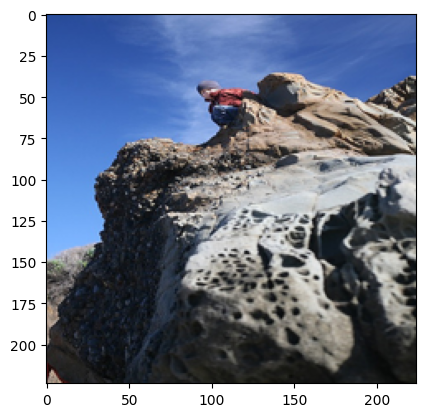

Caption: dog is running through the snow |||| sentiment: 😐


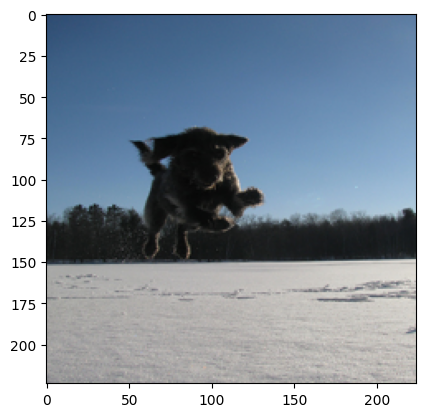

Caption: two dogs are playing with each other in the grass |||| sentiment: 😊


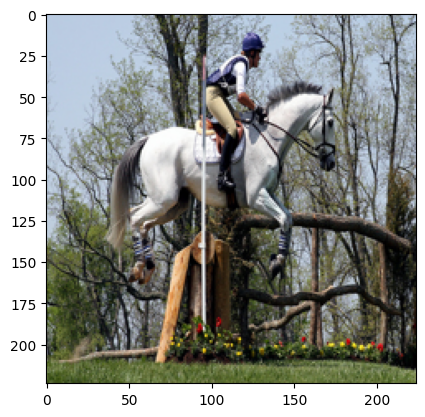

Caption: baseball player in red and white uniform is running on the field |||| sentiment: 😐


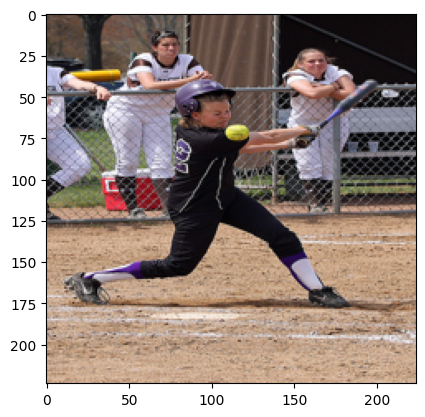

Caption: dog is running through the water |||| sentiment: 😐


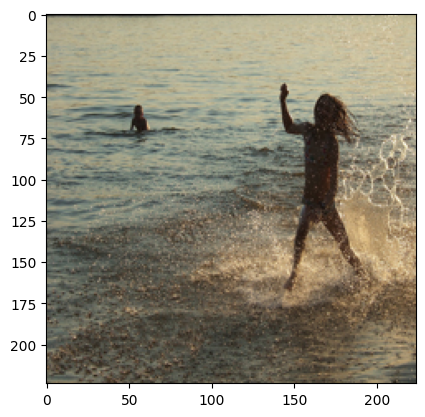

In [ ]:
for image_name in test[:10]:
    image_path = os.path.join(image_path_file, image_name + '.jpg')
    image = Image.open(image_path)
    image = image.resize((224, 224))
    caption = predict_caption(model, features[image_name], token, max_length)
    words = caption.split()
    caption = ' '.join(words[1:-1])   # remove startseq and endseq from begin and end of captions
    stop_words = set(stopwords.words('english'))
    filtered_caption = ' '.join(word for word in caption.split() if word.lower() not in stop_words)
    sentiment = analyze_sentiment(filtered_caption)
    plt.imshow(image)
    print(f"Caption: {caption}" + f" |||| sentiment: {sentiment}")
    plt.show()


In [ ]:
modelTest = VGG16(weights='imagenet')

Caption: surfer is riding wave ||| sentiment: 😐


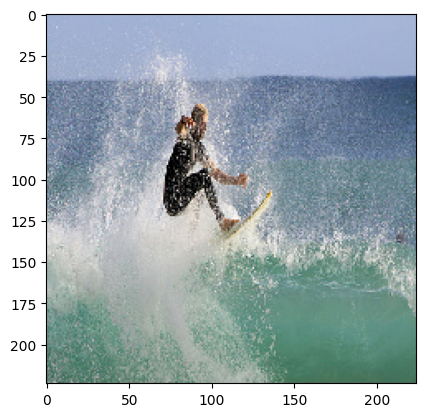

In [ ]:
image_path = os.path.join('/content/drive/MyDrive/Assessment', '7526599338' + '.jpg')
image = load_img(image_path, target_size=(224, 224))
image = image.resize((224, 224))
plt.imshow(image)
image = img_to_array(image)
image = image.reshape((1,image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)
feature = modelTest.predict(image, verbose=0)
caption1 = predict_caption(model, feature, token, max_length)
words = caption1.split()
caption1 = ' '.join(words[1:-1])
stop_words = set(stopwords.words('english'))
filtered_caption1 = ' '.join(word for word in caption1.split() if word.lower() not in stop_words)
sentiment1 = analyze_sentiment(filtered_caption1)
print(f"Caption: {caption1}" + f" ||| sentiment: {sentiment1}")
plt.show()


# <font color = 'lightGreen'>BLEU SCORE</font>

In [ ]:
from nltk.translate.bleu_score import corpus_bleu


In [ ]:
actual, predicted = list(), list()
for key in test: # using test list

    captions = captions_mapping[key]  # load captions we have already

    y_pred = predict_caption(model, features[key], token, max_length)  # predict the caption for image

    actual_captions = [caption.split() for caption in captions] # split that caption from test into words
    y_pred = y_pred.split() # split predicted caption

    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0.0, 0.0, 0.0))) # using corpus_bleu

BLEU: 0.536094
